In [1]:
import os
import time
import warnings
import numpy as np
import cvxpy as cp
import pandas as pd
from tqdm import tqdm
from scipy.linalg import orth
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from matplotlib.ticker import LogFormatter
from scipy.optimize import minimize, linprog
from scipy.optimize import differential_evolution, NonlinearConstraint
np.random.seed(1)
warnings.filterwarnings("ignore")

In [2]:
def generate_action_set(trials, iterations, M, num_action, d, k):
    
    Action_list = np.zeros((trials, iterations, M, num_action, d))
    Theta_list = np.zeros((trials, d, M))
    B_star_list = np.zeros((trials, d, k))

    for T in range(trials):

        for m in range(M):

            Action_list[T, :, m, :, :] = np.random.randn(iterations, num_action, d)

        B_star = orth(np.random.rand(d, k))
        W_star = np.random.rand(k, M)
        Theta_star = np.dot(B_star, W_star)
        
        B_star_list[T] = B_star
        Theta_list[T] = Theta_star
        
    return Action_list, Theta_list, B_star_list

In [3]:
def init_altgdmin(X, t, Y, C, M, d, k):
    
    alpha = C * np.linalg.norm(Y, 'fro') / np.sqrt(t * M)
    Y_trunc = np.where(np.abs(Y) > alpha, 0, Y)
    
    Theta_0 = np.zeros((d, M))
    
    for i in range(M):
        
        Theta_0[:, i] = np.sum(X[i].dot(np.diag(Y_trunc[i])), axis=1) / t
    
    U_0, Sigma_0, V_0 = np.linalg.svd(Theta_0, full_matrices = False)
    
    return U_0[:, :k]

In [4]:
def get_beta_our(sigma, k, n, L, ld, delta, S, N):
    
    beta = sigma * np.sqrt(k * np.log((1 + n * np.square(L) / ld) / delta)) + ((1 + 1 / np.sqrt(N)) * np.sqrt(ld) + 2 * np.sqrt(n / N)) * S
    
    return beta

In [5]:
def get_beta_ohter_estimator(sigma, k, n, L, ld, delta, S, delta_0):
    
    beta = sigma * np.sqrt(k * np.log((1 + n * np.square(L) / ld) / delta)) + ((1 + delta_0) * np.sqrt(ld) + 2 * np.sqrt(n) * L * delta_0) * S
    
    return beta

In [6]:
def get_beta_Abbasi(sigma, k, n, L, ld, delta, S):
    
    beta = sigma * np.sqrt(k * np.log((1 + n * np.square(L) / ld) / delta)) + np.sqrt(ld) * S
    
    return beta

In [7]:
# cvxpy
def get_decision(action_set, theta_hat, V, beta, d):

    theta_list = []
    reward_list = []

    for action in action_set: 

        V_psd = cp.psd_wrap(V)
        theta = cp.Variable(d)
        objective = cp.Maximize(action.T @ theta)
        constraint = cp.quad_form(theta - theta_hat, V_psd) <= beta ** 2
        
        problem = cp.Problem(objective, [constraint])
        problem.solve(solver=cp.ECOS, abstol=1e-8, reltol=1e-8)

        # print(problem.status)
        
        theta_list.append(theta.value)
        reward_list.append(action.dot(theta.value))

    decision = np.argmax(reward_list)
    theta_tilde = theta_list[decision]
    
    return decision, theta_tilde

In [8]:
CR_Trials = []
CR_Trials_Abbasi = []
CR_Trials_MOM = []
d = 100
M = 200
k = 2
C = 3
ld = 1
trials = 100
delta = 1e-3
sigma = 1e-1
num_action = 5
every_point = 25
epoch_iter = 400
epoch_iter_2 = 200
iterations = epoch_iter + epoch_iter_2
A, Theta, B_star_list = generate_action_set(trials, iterations, M+1, num_action, d, k)

In [9]:
# generate the noise of reward for each iteration
noise_list = np.random.normal(0, sigma ** 2, size = (trials, iterations, M+1))

In [10]:
# Our Algorithm
start = time.time()

for T in tqdm(range(trials), desc = 'trials'):
    
#     print('Trial:', T)
    
    action_set = A[T]
    B_star = B_star_list[T]
    Theta_star = Theta[T]
    noise_T = noise_list[T]

    L = np.max(np.linalg.norm(action_set[:, -1, :, :], axis=-1))
    S = np.linalg.norm(Theta_star[:, -1])
    
    B_hat = np.zeros((d, k))
    W_hat = np.zeros((k, M))
    Theta_hat = B_hat.dot(W_hat)
    w_hat = np.zeros(k)
    theta_hat = B_hat.dot(w_hat)
    
    cumulative_regret = 0
    cummulative_regret_list = []
    
    X = np.zeros((M, d, epoch_iter))
    Y = np.zeros((M, epoch_iter))
    V = ld * np.eye(d)
    U = np.zeros((k, 1))
    
    for t in range(epoch_iter):
        
        for i in range(M):
            
            action = np.argmax(np.dot(action_set[t, i], Theta_hat[:, i]))
            reward = action_set[t, i, action].dot(Theta_star[:, i])
            
            X[i, :, t] = action_set[t, i, action]
            Y[i, t] = reward + noise_T[t, i]
            
    B_hat = init_altgdmin(X, epoch_iter, Y, C, M, d, k)
    delta_0 = np.linalg.norm((np.eye(d)-B_star.dot(B_star.T)).dot(B_hat), ord='fro')
    print('subspace distance error is:', delta_0)
    
    for t in range(epoch_iter, iterations):
        
        beta = get_beta_our(sigma, k, t - epoch_iter + 1, L, ld, delta, S, iterations - epoch_iter)
        decision, theta_tilde = get_decision(action_set[t, -1], theta_hat, V, beta, d)
        
        reward = action_set[t, -1, decision].dot(Theta_star[:, -1])
        cumulative_regret += np.max(np.dot(action_set[t, -1], Theta_star[:, -1])) - reward
        
        V += action_set[t, -1, decision].reshape(-1, 1).dot(action_set[t, -1, decision].reshape(1, -1))
        U += B_hat.T.dot(action_set[t, -1, decision].reshape(-1, 1)) * (reward + noise_T[t, -1])
        w_hat = np.linalg.inv(B_hat.T.dot(V).dot(B_hat)).dot(U).reshape(-1)
        theta_hat = B_hat.dot(w_hat)
            
        cummulative_regret_list.append(cumulative_regret)
        # print('parameter error is {} and cumulative regret is {}'.format(np.linalg.norm(theta_hat-Theta_star[:, -1]), cumulative_regret))
            
    CR_Trials.append((T, cummulative_regret_list))
    
end = time.time()
print('Finished! The total time we use is: ', end - start)

trials:   0%|          | 0/100 [00:00<?, ?it/s]

subspace distance error is: 0.10949972063118743


trials:   1%|          | 1/100 [00:16<27:10, 16.47s/it]

subspace distance error is: 0.12427976964214311


trials:   2%|▏         | 2/100 [00:32<26:52, 16.46s/it]

subspace distance error is: 0.11355351651140146


trials:   3%|▎         | 3/100 [00:49<26:49, 16.60s/it]

subspace distance error is: 0.1265039116378269


trials:   4%|▍         | 4/100 [01:06<26:53, 16.81s/it]

subspace distance error is: 0.11641094091504571


trials:   5%|▌         | 5/100 [01:26<28:15, 17.84s/it]

subspace distance error is: 0.1170759034603606


trials:   6%|▌         | 6/100 [01:45<28:24, 18.13s/it]

subspace distance error is: 0.11378729460031356


trials:   7%|▋         | 7/100 [02:02<27:39, 17.84s/it]

subspace distance error is: 0.11754344397326463


trials:   8%|▊         | 8/100 [02:19<27:06, 17.68s/it]

subspace distance error is: 0.12878712455879934


trials:   9%|▉         | 9/100 [02:38<27:21, 18.03s/it]

subspace distance error is: 0.12407183284180495


trials:  10%|█         | 10/100 [02:56<27:00, 18.00s/it]

subspace distance error is: 0.12633008358572434


trials:  11%|█         | 11/100 [03:14<26:29, 17.86s/it]

subspace distance error is: 0.115789742119064


trials:  12%|█▏        | 12/100 [03:32<26:29, 18.07s/it]

subspace distance error is: 0.12420931515140585


trials:  13%|█▎        | 13/100 [03:50<26:02, 17.96s/it]

subspace distance error is: 0.11765075852516642


trials:  14%|█▍        | 14/100 [04:07<25:17, 17.64s/it]

subspace distance error is: 0.11596064055675177


trials:  15%|█▌        | 15/100 [04:24<24:53, 17.57s/it]

subspace distance error is: 0.10925075427701617


trials:  16%|█▌        | 16/100 [04:42<24:41, 17.64s/it]

subspace distance error is: 0.11562540974263312


trials:  17%|█▋        | 17/100 [04:59<24:07, 17.43s/it]

subspace distance error is: 0.102753563478875


trials:  18%|█▊        | 18/100 [05:16<23:34, 17.26s/it]

subspace distance error is: 0.12258402285752933


trials:  19%|█▉        | 19/100 [05:33<23:20, 17.29s/it]

subspace distance error is: 0.12102913794820115


trials:  20%|██        | 20/100 [05:50<23:03, 17.30s/it]

subspace distance error is: 0.12393253759662097


trials:  21%|██        | 21/100 [06:09<23:27, 17.82s/it]

subspace distance error is: 0.12104046265319691


trials:  22%|██▏       | 22/100 [06:27<23:11, 17.84s/it]

subspace distance error is: 0.11512430419104962


trials:  23%|██▎       | 23/100 [06:44<22:34, 17.59s/it]

subspace distance error is: 0.11810554429361478


trials:  24%|██▍       | 24/100 [07:01<21:49, 17.23s/it]

subspace distance error is: 0.11817578643685592


trials:  25%|██▌       | 25/100 [07:18<21:32, 17.23s/it]

subspace distance error is: 0.10843382011338557


trials:  26%|██▌       | 26/100 [07:34<20:57, 17.00s/it]

subspace distance error is: 0.11851700548383666


trials:  27%|██▋       | 27/100 [07:51<20:35, 16.92s/it]

subspace distance error is: 0.10611203768808163


trials:  28%|██▊       | 28/100 [08:09<20:27, 17.05s/it]

subspace distance error is: 0.12055711312455177


trials:  29%|██▉       | 29/100 [08:26<20:24, 17.24s/it]

subspace distance error is: 0.12827222319914888


trials:  30%|███       | 30/100 [08:43<20:04, 17.21s/it]

subspace distance error is: 0.10953227248259507


trials:  31%|███       | 31/100 [09:00<19:36, 17.05s/it]

subspace distance error is: 0.11192158427131568


trials:  32%|███▏      | 32/100 [09:17<19:12, 16.95s/it]

subspace distance error is: 0.12507304681129938


trials:  33%|███▎      | 33/100 [09:36<19:33, 17.52s/it]

subspace distance error is: 0.11113512796417023


trials:  34%|███▍      | 34/100 [09:52<18:58, 17.25s/it]

subspace distance error is: 0.11531916924294938


trials:  35%|███▌      | 35/100 [10:10<18:43, 17.28s/it]

subspace distance error is: 0.11398347438385986


trials:  36%|███▌      | 36/100 [10:27<18:22, 17.23s/it]

subspace distance error is: 0.10915447447560751


trials:  37%|███▋      | 37/100 [10:44<18:01, 17.17s/it]

subspace distance error is: 0.12094680566275752


trials:  38%|███▊      | 38/100 [11:03<18:19, 17.74s/it]

subspace distance error is: 0.11044261665134128


trials:  39%|███▉      | 39/100 [11:20<17:54, 17.61s/it]

subspace distance error is: 0.1148472867540375


trials:  40%|████      | 40/100 [11:39<17:58, 17.97s/it]

subspace distance error is: 0.09901475186526976


trials:  41%|████      | 41/100 [11:56<17:29, 17.79s/it]

subspace distance error is: 0.11486078502640314


trials:  42%|████▏     | 42/100 [12:15<17:36, 18.22s/it]

subspace distance error is: 0.11559076290157837


trials:  43%|████▎     | 43/100 [12:32<16:48, 17.69s/it]

subspace distance error is: 0.11106399571181906


trials:  44%|████▍     | 44/100 [12:49<16:22, 17.54s/it]

subspace distance error is: 0.10704804772311083


trials:  45%|████▌     | 45/100 [13:07<16:03, 17.52s/it]

subspace distance error is: 0.12485834368109798


trials:  46%|████▌     | 46/100 [13:24<15:44, 17.49s/it]

subspace distance error is: 0.11784686515122525


trials:  47%|████▋     | 47/100 [13:42<15:40, 17.75s/it]

subspace distance error is: 0.10474697687026288


trials:  48%|████▊     | 48/100 [13:59<15:11, 17.53s/it]

subspace distance error is: 0.1042013344689656


trials:  49%|████▉     | 49/100 [14:17<14:56, 17.57s/it]

subspace distance error is: 0.10577920313202352


trials:  50%|█████     | 50/100 [14:36<15:04, 18.09s/it]

subspace distance error is: 0.10973834011772093


trials:  51%|█████     | 51/100 [14:54<14:43, 18.04s/it]

subspace distance error is: 0.1266307561227533


trials:  52%|█████▏    | 52/100 [15:11<14:07, 17.66s/it]

subspace distance error is: 0.11360035873602711


trials:  53%|█████▎    | 53/100 [15:29<13:48, 17.63s/it]

subspace distance error is: 0.10775644940816771


trials:  54%|█████▍    | 54/100 [15:46<13:27, 17.56s/it]

subspace distance error is: 0.10619317314300941


trials:  55%|█████▌    | 55/100 [16:03<13:05, 17.46s/it]

subspace distance error is: 0.11637676456634073


trials:  56%|█████▌    | 56/100 [16:20<12:42, 17.32s/it]

subspace distance error is: 0.10587922771893554


trials:  57%|█████▋    | 57/100 [16:39<12:49, 17.89s/it]

subspace distance error is: 0.12557607846128735


trials:  58%|█████▊    | 58/100 [16:57<12:32, 17.91s/it]

subspace distance error is: 0.11424097907335141


trials:  59%|█████▉    | 59/100 [17:15<12:08, 17.76s/it]

subspace distance error is: 0.10931772520514614


trials:  60%|██████    | 60/100 [17:32<11:44, 17.60s/it]

subspace distance error is: 0.11291545368229283


trials:  61%|██████    | 61/100 [17:51<11:38, 17.91s/it]

subspace distance error is: 0.11360063514260614


trials:  62%|██████▏   | 62/100 [18:08<11:16, 17.81s/it]

subspace distance error is: 0.11686638707786347


trials:  63%|██████▎   | 63/100 [18:27<11:10, 18.11s/it]

subspace distance error is: 0.12235477802398975


trials:  64%|██████▍   | 64/100 [18:46<11:02, 18.39s/it]

subspace distance error is: 0.10204372957632676


trials:  65%|██████▌   | 65/100 [19:05<10:45, 18.44s/it]

subspace distance error is: 0.11048505462017297


trials:  66%|██████▌   | 66/100 [19:22<10:15, 18.09s/it]

subspace distance error is: 0.11155679756601276


trials:  67%|██████▋   | 67/100 [19:40<09:59, 18.17s/it]

subspace distance error is: 0.12985906051061502


trials:  68%|██████▊   | 68/100 [19:58<09:33, 17.93s/it]

subspace distance error is: 0.12349337499361462


trials:  69%|██████▉   | 69/100 [20:15<09:08, 17.70s/it]

subspace distance error is: 0.10470109924987131


trials:  70%|███████   | 70/100 [20:32<08:48, 17.61s/it]

subspace distance error is: 0.11263843432665084


trials:  71%|███████   | 71/100 [20:49<08:22, 17.33s/it]

subspace distance error is: 0.12081044235576127


trials:  72%|███████▏  | 72/100 [21:06<08:03, 17.28s/it]

subspace distance error is: 0.11420954843326325


trials:  73%|███████▎  | 73/100 [21:23<07:43, 17.15s/it]

subspace distance error is: 0.11476054364444398


trials:  74%|███████▍  | 74/100 [21:40<07:24, 17.08s/it]

subspace distance error is: 0.11947855892021236


trials:  75%|███████▌  | 75/100 [21:58<07:11, 17.28s/it]

subspace distance error is: 0.12494337653062627


trials:  76%|███████▌  | 76/100 [22:15<06:55, 17.32s/it]

subspace distance error is: 0.11078353845348939


trials:  77%|███████▋  | 77/100 [22:32<06:35, 17.19s/it]

subspace distance error is: 0.12071112905101186


trials:  78%|███████▊  | 78/100 [22:49<06:19, 17.24s/it]

subspace distance error is: 0.1035622211773665


trials:  79%|███████▉  | 79/100 [23:07<06:02, 17.28s/it]

subspace distance error is: 0.10671222871245055


trials:  80%|████████  | 80/100 [23:24<05:45, 17.26s/it]

subspace distance error is: 0.10791638028450161


trials:  81%|████████  | 81/100 [23:42<05:30, 17.41s/it]

subspace distance error is: 0.11509425361789348


trials:  82%|████████▏ | 82/100 [24:00<05:19, 17.76s/it]

subspace distance error is: 0.10777408981784095


trials:  83%|████████▎ | 83/100 [24:18<05:01, 17.76s/it]

subspace distance error is: 0.10731623443955614


trials:  84%|████████▍ | 84/100 [24:36<04:46, 17.88s/it]

subspace distance error is: 0.12809641065397395


trials:  85%|████████▌ | 85/100 [24:54<04:30, 18.00s/it]

subspace distance error is: 0.11315548373202675


trials:  86%|████████▌ | 86/100 [25:14<04:19, 18.50s/it]

subspace distance error is: 0.12186144901025783


trials:  87%|████████▋ | 87/100 [25:31<03:55, 18.10s/it]

subspace distance error is: 0.11282649666499617


trials:  88%|████████▊ | 88/100 [25:49<03:34, 17.89s/it]

subspace distance error is: 0.11470762601201899


trials:  89%|████████▉ | 89/100 [26:06<03:16, 17.87s/it]

subspace distance error is: 0.11671214549338477


trials:  90%|█████████ | 90/100 [26:25<03:00, 18.06s/it]

subspace distance error is: 0.10528608678303226


trials:  91%|█████████ | 91/100 [26:43<02:43, 18.19s/it]

subspace distance error is: 0.12249993103881232


trials:  92%|█████████▏| 92/100 [27:00<02:22, 17.79s/it]

subspace distance error is: 0.11286624171790521


trials:  93%|█████████▎| 93/100 [27:17<02:03, 17.58s/it]

subspace distance error is: 0.12959080844023463


trials:  94%|█████████▍| 94/100 [27:35<01:45, 17.52s/it]

subspace distance error is: 0.11237202232783011


trials:  95%|█████████▌| 95/100 [27:51<01:25, 17.11s/it]

subspace distance error is: 0.11686290055395754


trials:  96%|█████████▌| 96/100 [28:09<01:09, 17.26s/it]

subspace distance error is: 0.12123185966221299


trials:  97%|█████████▋| 97/100 [28:27<00:52, 17.60s/it]

subspace distance error is: 0.10562380397260077


trials:  98%|█████████▊| 98/100 [28:44<00:34, 17.46s/it]

subspace distance error is: 0.11457298885074478


trials:  99%|█████████▉| 99/100 [29:02<00:17, 17.71s/it]

subspace distance error is: 0.10992589369953334


trials: 100%|██████████| 100/100 [29:20<00:00, 17.60s/it]

Finished! The total time we use is:  1760.5436556339264


In [11]:
# Abbasi Algorithm
start = time.time()

for T in tqdm(range(trials), desc = 'trials'):
    
#     print('Trial:', T)
    
    action_set = A[T]
    Theta_star = Theta[T]
    noise_T = noise_list[T]

    L = np.max(np.linalg.norm(action_set[:, -1, :, :], axis=-1))
    S = np.linalg.norm(Theta_star[:, -1])
    
    theta_hat = np.zeros(d)
    
    cumulative_regret = 0
    cummulative_regret_list = []
    
    V = ld * np.eye(d)
    U = np.zeros((d, 1))
    
    for t in range(epoch_iter, iterations):
        
        beta = get_beta_Abbasi(sigma, d, t - epoch_iter + 1, L, ld, delta, S)
        decision, theta_tilde = get_decision(action_set[t, -1], theta_hat, V, beta, d)
        
        reward = action_set[t, -1, decision].dot(Theta_star[:, -1])
        cumulative_regret += np.max(np.dot(action_set[t, -1], Theta_star[:, -1])) - reward
        
        V += action_set[t, -1, decision].reshape(-1, 1).dot(action_set[t, -1, decision].reshape(1, -1))
        U += action_set[t, -1, decision].reshape(-1, 1) * (reward + noise_T[t, -1])
        theta_hat = np.linalg.inv(V).dot(U).reshape(-1)
            
        cummulative_regret_list.append(cumulative_regret)
        # print('cumulative regret is {}'.format(cumulative_regret))
            
    CR_Trials_Abbasi.append((T, cummulative_regret_list))
    
end = time.time()
print('Finished! The total time we use is: ', end - start)

trials: 100%|██████████| 100/100 [27:32<00:00, 16.52s/it]

Finished! The total time we use is:  1652.503741979599


In [12]:
# MOM
start = time.time()

for T in tqdm(range(trials), desc = 'trials'):
    
#     print('Trial:', T)
    
    action_set = A[T]
    B_star = B_star_list[T]
    Theta_star = Theta[T]
    noise_T = noise_list[T]

    L = np.max(np.linalg.norm(action_set[:, -1, :, :], axis=-1))
    S = np.linalg.norm(Theta_star[:, -1])
    
    B_hat = np.zeros((d, k))
    W_hat = np.zeros((k, M))
    Theta_hat = B_hat.dot(W_hat)
    w_hat = np.zeros(k)
    theta_hat = B_hat.dot(w_hat)
    
    cumulative_regret = 0
    cummulative_regret_list = []

    M_hat = np.zeros((d, d))
    V = ld * np.eye(d)
    U = np.zeros((k, 1))
    
    for t in range(epoch_iter):
        
        for i in range(M):
            
            action = np.argmax(np.dot(action_set[t, i], Theta_hat[:, i]))
            reward = action_set[t, i, action].dot(Theta_star[:, i])

            M_hat += (reward + noise_T[t, i]) ** 2 * np.dot(action_set[t, i, action].reshape(-1, 1), action_set[t, i, action].reshape(1, -1))

    M_hat /= epoch_iter * M
    B_hat = np.linalg.svd(M_hat, full_matrices=False)[0][:, :k]
    
    delta_0 = np.linalg.norm((np.eye(d)-B_star.dot(B_star.T)).dot(B_hat), ord='fro')
    print('subspace distance error is:', delta_0)
    
    for t in range(epoch_iter, iterations):
        
        beta = get_beta_ohter_estimator(sigma, k, t - epoch_iter + 1, L, ld, delta, S, delta_0)
        decision, theta_tilde = get_decision(action_set[t, -1], theta_hat, V, beta, d)
        
        reward = action_set[t, -1, decision].dot(Theta_star[:, -1])
        cumulative_regret += np.max(np.dot(action_set[t, -1], Theta_star[:, -1])) - reward
        
        V += action_set[t, -1, decision].reshape(-1, 1).dot(action_set[t, -1, decision].reshape(1, -1))
        U += B_hat.T.dot(action_set[t, -1, decision].reshape(-1, 1)) * (reward + noise_T[t, -1])
        w_hat = np.linalg.inv(B_hat.T.dot(V).dot(B_hat)).dot(U).reshape(-1)
        theta_hat = B_hat.dot(w_hat)
            
        cummulative_regret_list.append(cumulative_regret)
        # print('parameter error is {} and cumulative regret is {}'.format(np.linalg.norm(theta_hat-Theta_star[:, -1]), cumulative_regret))
            
    CR_Trials_MOM.append((T, cummulative_regret_list))
    
end = time.time()
print('Finished! The total time we use is: ', end - start)

trials:   0%|          | 0/100 [00:00<?, ?it/s]

subspace distance error is: 0.3835815276736477


trials:   1%|          | 1/100 [00:16<27:41, 16.78s/it]

subspace distance error is: 0.39745314495639167


trials:   2%|▏         | 2/100 [00:32<26:45, 16.38s/it]

subspace distance error is: 0.3521950609028064


trials:   3%|▎         | 3/100 [00:49<26:58, 16.69s/it]

subspace distance error is: 0.3682036806821584


trials:   4%|▍         | 4/100 [01:06<26:40, 16.67s/it]

subspace distance error is: 0.34973100258544826


trials:   5%|▌         | 5/100 [01:25<27:54, 17.63s/it]

subspace distance error is: 0.3516744511216981


trials:   6%|▌         | 6/100 [01:44<28:05, 17.93s/it]

subspace distance error is: 0.4255606705699342


trials:   7%|▋         | 7/100 [02:01<27:15, 17.59s/it]

subspace distance error is: 0.3395060306663118


trials:   8%|▊         | 8/100 [02:18<26:47, 17.47s/it]

subspace distance error is: 0.3636277020534375


trials:   9%|▉         | 9/100 [02:36<26:45, 17.64s/it]

subspace distance error is: 0.40462329648205425


trials:  10%|█         | 10/100 [02:53<26:08, 17.43s/it]

subspace distance error is: 0.3920227389136776


trials:  11%|█         | 11/100 [03:10<25:40, 17.31s/it]

subspace distance error is: 0.33758904848894694


trials:  12%|█▏        | 12/100 [03:28<25:41, 17.52s/it]

subspace distance error is: 0.3738713210915362


trials:  13%|█▎        | 13/100 [03:46<25:28, 17.57s/it]

subspace distance error is: 0.3194441870189919


trials:  14%|█▍        | 14/100 [04:03<24:59, 17.43s/it]

subspace distance error is: 0.3912771160736352


trials:  15%|█▌        | 15/100 [04:20<24:32, 17.32s/it]

subspace distance error is: 0.33607182417237247


trials:  16%|█▌        | 16/100 [04:36<23:55, 17.09s/it]

subspace distance error is: 0.3287679023526523


trials:  17%|█▋        | 17/100 [04:54<23:49, 17.23s/it]

subspace distance error is: 0.3295857543541953


trials:  18%|█▊        | 18/100 [05:11<23:29, 17.18s/it]

subspace distance error is: 0.3209102492261294


trials:  19%|█▉        | 19/100 [05:28<22:56, 16.99s/it]

subspace distance error is: 0.29053145679141007


trials:  20%|██        | 20/100 [05:45<22:46, 17.08s/it]

subspace distance error is: 0.3628629657905631


trials:  21%|██        | 21/100 [06:00<21:50, 16.59s/it]

subspace distance error is: 0.3575390695381556


trials:  22%|██▏       | 22/100 [06:17<21:32, 16.58s/it]

subspace distance error is: 0.32638825616001216


trials:  23%|██▎       | 23/100 [06:33<21:13, 16.53s/it]

subspace distance error is: 0.3724162359859419


trials:  24%|██▍       | 24/100 [06:49<20:44, 16.37s/it]

subspace distance error is: 0.36347398977834827


trials:  25%|██▌       | 25/100 [07:06<20:42, 16.57s/it]

subspace distance error is: 0.39568193148135133


trials:  26%|██▌       | 26/100 [07:23<20:23, 16.53s/it]

subspace distance error is: 0.33151978996283943


trials:  27%|██▋       | 27/100 [07:39<20:03, 16.48s/it]

subspace distance error is: 0.3407760700704263


trials:  28%|██▊       | 28/100 [07:56<19:51, 16.55s/it]

subspace distance error is: 0.41507667246125557


trials:  29%|██▉       | 29/100 [08:12<19:31, 16.49s/it]

subspace distance error is: 0.4198439982904426


trials:  30%|███       | 30/100 [08:29<19:16, 16.53s/it]

subspace distance error is: 0.3177306500472014


trials:  31%|███       | 31/100 [08:45<19:02, 16.55s/it]

subspace distance error is: 0.3273704942837613


trials:  32%|███▏      | 32/100 [09:02<18:40, 16.48s/it]

subspace distance error is: 0.3474208094726574


trials:  33%|███▎      | 33/100 [09:17<18:05, 16.19s/it]

subspace distance error is: 0.3257194384826073


trials:  34%|███▍      | 34/100 [09:34<17:50, 16.22s/it]

subspace distance error is: 0.3265297378667964


trials:  35%|███▌      | 35/100 [09:51<17:53, 16.51s/it]

subspace distance error is: 0.3027799825074999


trials:  36%|███▌      | 36/100 [10:08<17:50, 16.72s/it]

subspace distance error is: 0.35218043676865773


trials:  37%|███▋      | 37/100 [10:26<17:52, 17.02s/it]

subspace distance error is: 0.34720038532574826


trials:  38%|███▊      | 38/100 [10:43<17:32, 16.97s/it]

subspace distance error is: 0.3326237198760778


trials:  39%|███▉      | 39/100 [10:59<17:06, 16.83s/it]

subspace distance error is: 0.43501456901449786


trials:  40%|████      | 40/100 [11:16<16:58, 16.97s/it]

subspace distance error is: 0.28534878636485855


trials:  41%|████      | 41/100 [11:33<16:42, 17.00s/it]

subspace distance error is: 0.3397595940513274


trials:  42%|████▏     | 42/100 [11:48<15:49, 16.38s/it]

subspace distance error is: 0.38411211744937734


trials:  43%|████▎     | 43/100 [12:05<15:39, 16.49s/it]

subspace distance error is: 0.42619189125301676


trials:  44%|████▍     | 44/100 [12:21<15:20, 16.44s/it]

subspace distance error is: 0.40537107174102227


trials:  45%|████▌     | 45/100 [12:38<15:02, 16.40s/it]

subspace distance error is: 0.3273575723026738


trials:  46%|████▌     | 46/100 [12:55<15:00, 16.68s/it]

subspace distance error is: 0.3661332037905615


trials:  47%|████▋     | 47/100 [13:10<14:16, 16.16s/it]

subspace distance error is: 0.3166405259698565


trials:  48%|████▊     | 48/100 [13:27<14:10, 16.36s/it]

subspace distance error is: 0.3332106479472951


trials:  49%|████▉     | 49/100 [13:44<14:01, 16.50s/it]

subspace distance error is: 0.39345989917004714


trials:  50%|█████     | 50/100 [13:59<13:27, 16.16s/it]

subspace distance error is: 0.36877322863578316


trials:  51%|█████     | 51/100 [14:16<13:24, 16.41s/it]

subspace distance error is: 0.40764219115382616


trials:  52%|█████▏    | 52/100 [14:32<13:05, 16.37s/it]

subspace distance error is: 0.35980683264464997


trials:  53%|█████▎    | 53/100 [14:49<12:48, 16.36s/it]

subspace distance error is: 0.3099217435742156


trials:  54%|█████▍    | 54/100 [15:05<12:36, 16.45s/it]

subspace distance error is: 0.3035175165135449


trials:  55%|█████▌    | 55/100 [15:22<12:25, 16.56s/it]

subspace distance error is: 0.33198850734499497


trials:  56%|█████▌    | 56/100 [15:38<12:06, 16.51s/it]

subspace distance error is: 0.3398307849531831


trials:  57%|█████▋    | 57/100 [15:57<12:11, 17.01s/it]

subspace distance error is: 0.32086174307935766


trials:  58%|█████▊    | 58/100 [16:14<11:55, 17.04s/it]

subspace distance error is: 0.39258784905564065


trials:  59%|█████▉    | 59/100 [16:30<11:32, 16.89s/it]

subspace distance error is: 0.388133923350527


trials:  60%|██████    | 60/100 [16:47<11:10, 16.76s/it]

subspace distance error is: 0.32598217610294145


trials:  61%|██████    | 61/100 [17:03<10:46, 16.59s/it]

subspace distance error is: 0.38155830449175526


trials:  62%|██████▏   | 62/100 [17:20<10:35, 16.72s/it]

subspace distance error is: 0.29816764379613164


trials:  63%|██████▎   | 63/100 [17:35<10:02, 16.28s/it]

subspace distance error is: 0.35282540304039844


trials:  64%|██████▍   | 64/100 [17:54<10:10, 16.97s/it]

subspace distance error is: 0.3021791674490261


trials:  65%|██████▌   | 65/100 [18:09<09:37, 16.49s/it]

subspace distance error is: 0.38721343033868943


trials:  66%|██████▌   | 66/100 [18:26<09:20, 16.48s/it]

subspace distance error is: 0.35312225660819363


trials:  67%|██████▋   | 67/100 [18:42<09:02, 16.43s/it]

subspace distance error is: 0.3669260488684724


trials:  68%|██████▊   | 68/100 [18:59<08:49, 16.55s/it]

subspace distance error is: 0.4085362389556572


trials:  69%|██████▉   | 69/100 [19:15<08:33, 16.57s/it]

subspace distance error is: 0.34199317013211594


trials:  70%|███████   | 70/100 [19:32<08:20, 16.69s/it]

subspace distance error is: 0.3313281552907209


trials:  71%|███████   | 71/100 [19:49<08:02, 16.62s/it]

subspace distance error is: 0.3368018500277251


trials:  72%|███████▏  | 72/100 [20:05<07:44, 16.59s/it]

subspace distance error is: 0.4041352475917308


trials:  73%|███████▎  | 73/100 [20:22<07:26, 16.53s/it]

subspace distance error is: 0.3702524650674463


trials:  74%|███████▍  | 74/100 [20:38<07:07, 16.43s/it]

subspace distance error is: 0.3860636627076241


trials:  75%|███████▌  | 75/100 [20:55<06:58, 16.75s/it]

subspace distance error is: 0.3202305265719061


trials:  76%|███████▌  | 76/100 [21:13<06:45, 16.88s/it]

subspace distance error is: 0.31961010995117006


trials:  77%|███████▋  | 77/100 [21:29<06:26, 16.81s/it]

subspace distance error is: 0.33475089028663935


trials:  78%|███████▊  | 78/100 [21:46<06:11, 16.88s/it]

subspace distance error is: 0.3237416866421393


trials:  79%|███████▉  | 79/100 [22:03<05:53, 16.81s/it]

subspace distance error is: 0.3484862104818813


trials:  80%|████████  | 80/100 [22:20<05:35, 16.78s/it]

subspace distance error is: 0.36986708909470895


trials:  81%|████████  | 81/100 [22:37<05:21, 16.93s/it]

subspace distance error is: 0.3074637897125044


trials:  82%|████████▏ | 82/100 [22:54<05:05, 16.97s/it]

subspace distance error is: 0.34874778104449233


trials:  83%|████████▎ | 83/100 [23:11<04:50, 17.11s/it]

subspace distance error is: 0.28604452187871526


trials:  84%|████████▍ | 84/100 [23:29<04:34, 17.14s/it]

subspace distance error is: 0.339874131480356


trials:  85%|████████▌ | 85/100 [23:46<04:17, 17.14s/it]

subspace distance error is: 0.3544125248920521


trials:  86%|████████▌ | 86/100 [24:03<03:59, 17.13s/it]

subspace distance error is: 0.3903445174606033


trials:  87%|████████▋ | 87/100 [24:20<03:41, 17.05s/it]

subspace distance error is: 0.3484092450874121


trials:  88%|████████▊ | 88/100 [24:37<03:26, 17.23s/it]

subspace distance error is: 0.30983946670845863


trials:  89%|████████▉ | 89/100 [24:55<03:10, 17.35s/it]

subspace distance error is: 0.34903510717414177


trials:  90%|█████████ | 90/100 [25:12<02:51, 17.14s/it]

subspace distance error is: 0.45813790176578556


trials:  91%|█████████ | 91/100 [25:28<02:32, 16.93s/it]

subspace distance error is: 0.34380984159887684


trials:  92%|█████████▏| 92/100 [25:45<02:14, 16.86s/it]

subspace distance error is: 0.3739877050839887


trials:  93%|█████████▎| 93/100 [26:01<01:57, 16.74s/it]

subspace distance error is: 0.3678398207223479


trials:  94%|█████████▍| 94/100 [26:18<01:40, 16.67s/it]

subspace distance error is: 0.3236339985754489


trials:  95%|█████████▌| 95/100 [26:34<01:22, 16.53s/it]

subspace distance error is: 0.38366906025147174


trials:  96%|█████████▌| 96/100 [26:51<01:06, 16.62s/it]

subspace distance error is: 0.4747935567254566


trials:  97%|█████████▋| 97/100 [27:08<00:50, 16.84s/it]

subspace distance error is: 0.33548730158472084


trials:  98%|█████████▊| 98/100 [27:25<00:33, 16.80s/it]

subspace distance error is: 0.4430057549583195


trials:  99%|█████████▉| 99/100 [27:42<00:16, 16.95s/it]

subspace distance error is: 0.29962041080463236


trials: 100%|██████████| 100/100 [28:00<00:00, 16.80s/it]

Finished! The total time we use is:  1680.0655567646027


In [13]:
def prepare_plot_data(CR_Trials, iterations, trials):

    x_value = np.array([i for i in range(iterations)])
    y_value = np.zeros(iterations)

    for i in range(iterations):

        for T in range(trials):

            y_value[i] += CR_Trials[T][1][i]

    y_value = y_value / trials

    return x_value, y_value

In [14]:
x_proposed, y_proposed = prepare_plot_data(CR_Trials, iterations - epoch_iter, trials)
x_Abbasi, y_Abbasi = prepare_plot_data(CR_Trials_Abbasi, iterations - epoch_iter, trials)
x_MOM, y_MOM = prepare_plot_data(CR_Trials_MOM, iterations - epoch_iter, trials)

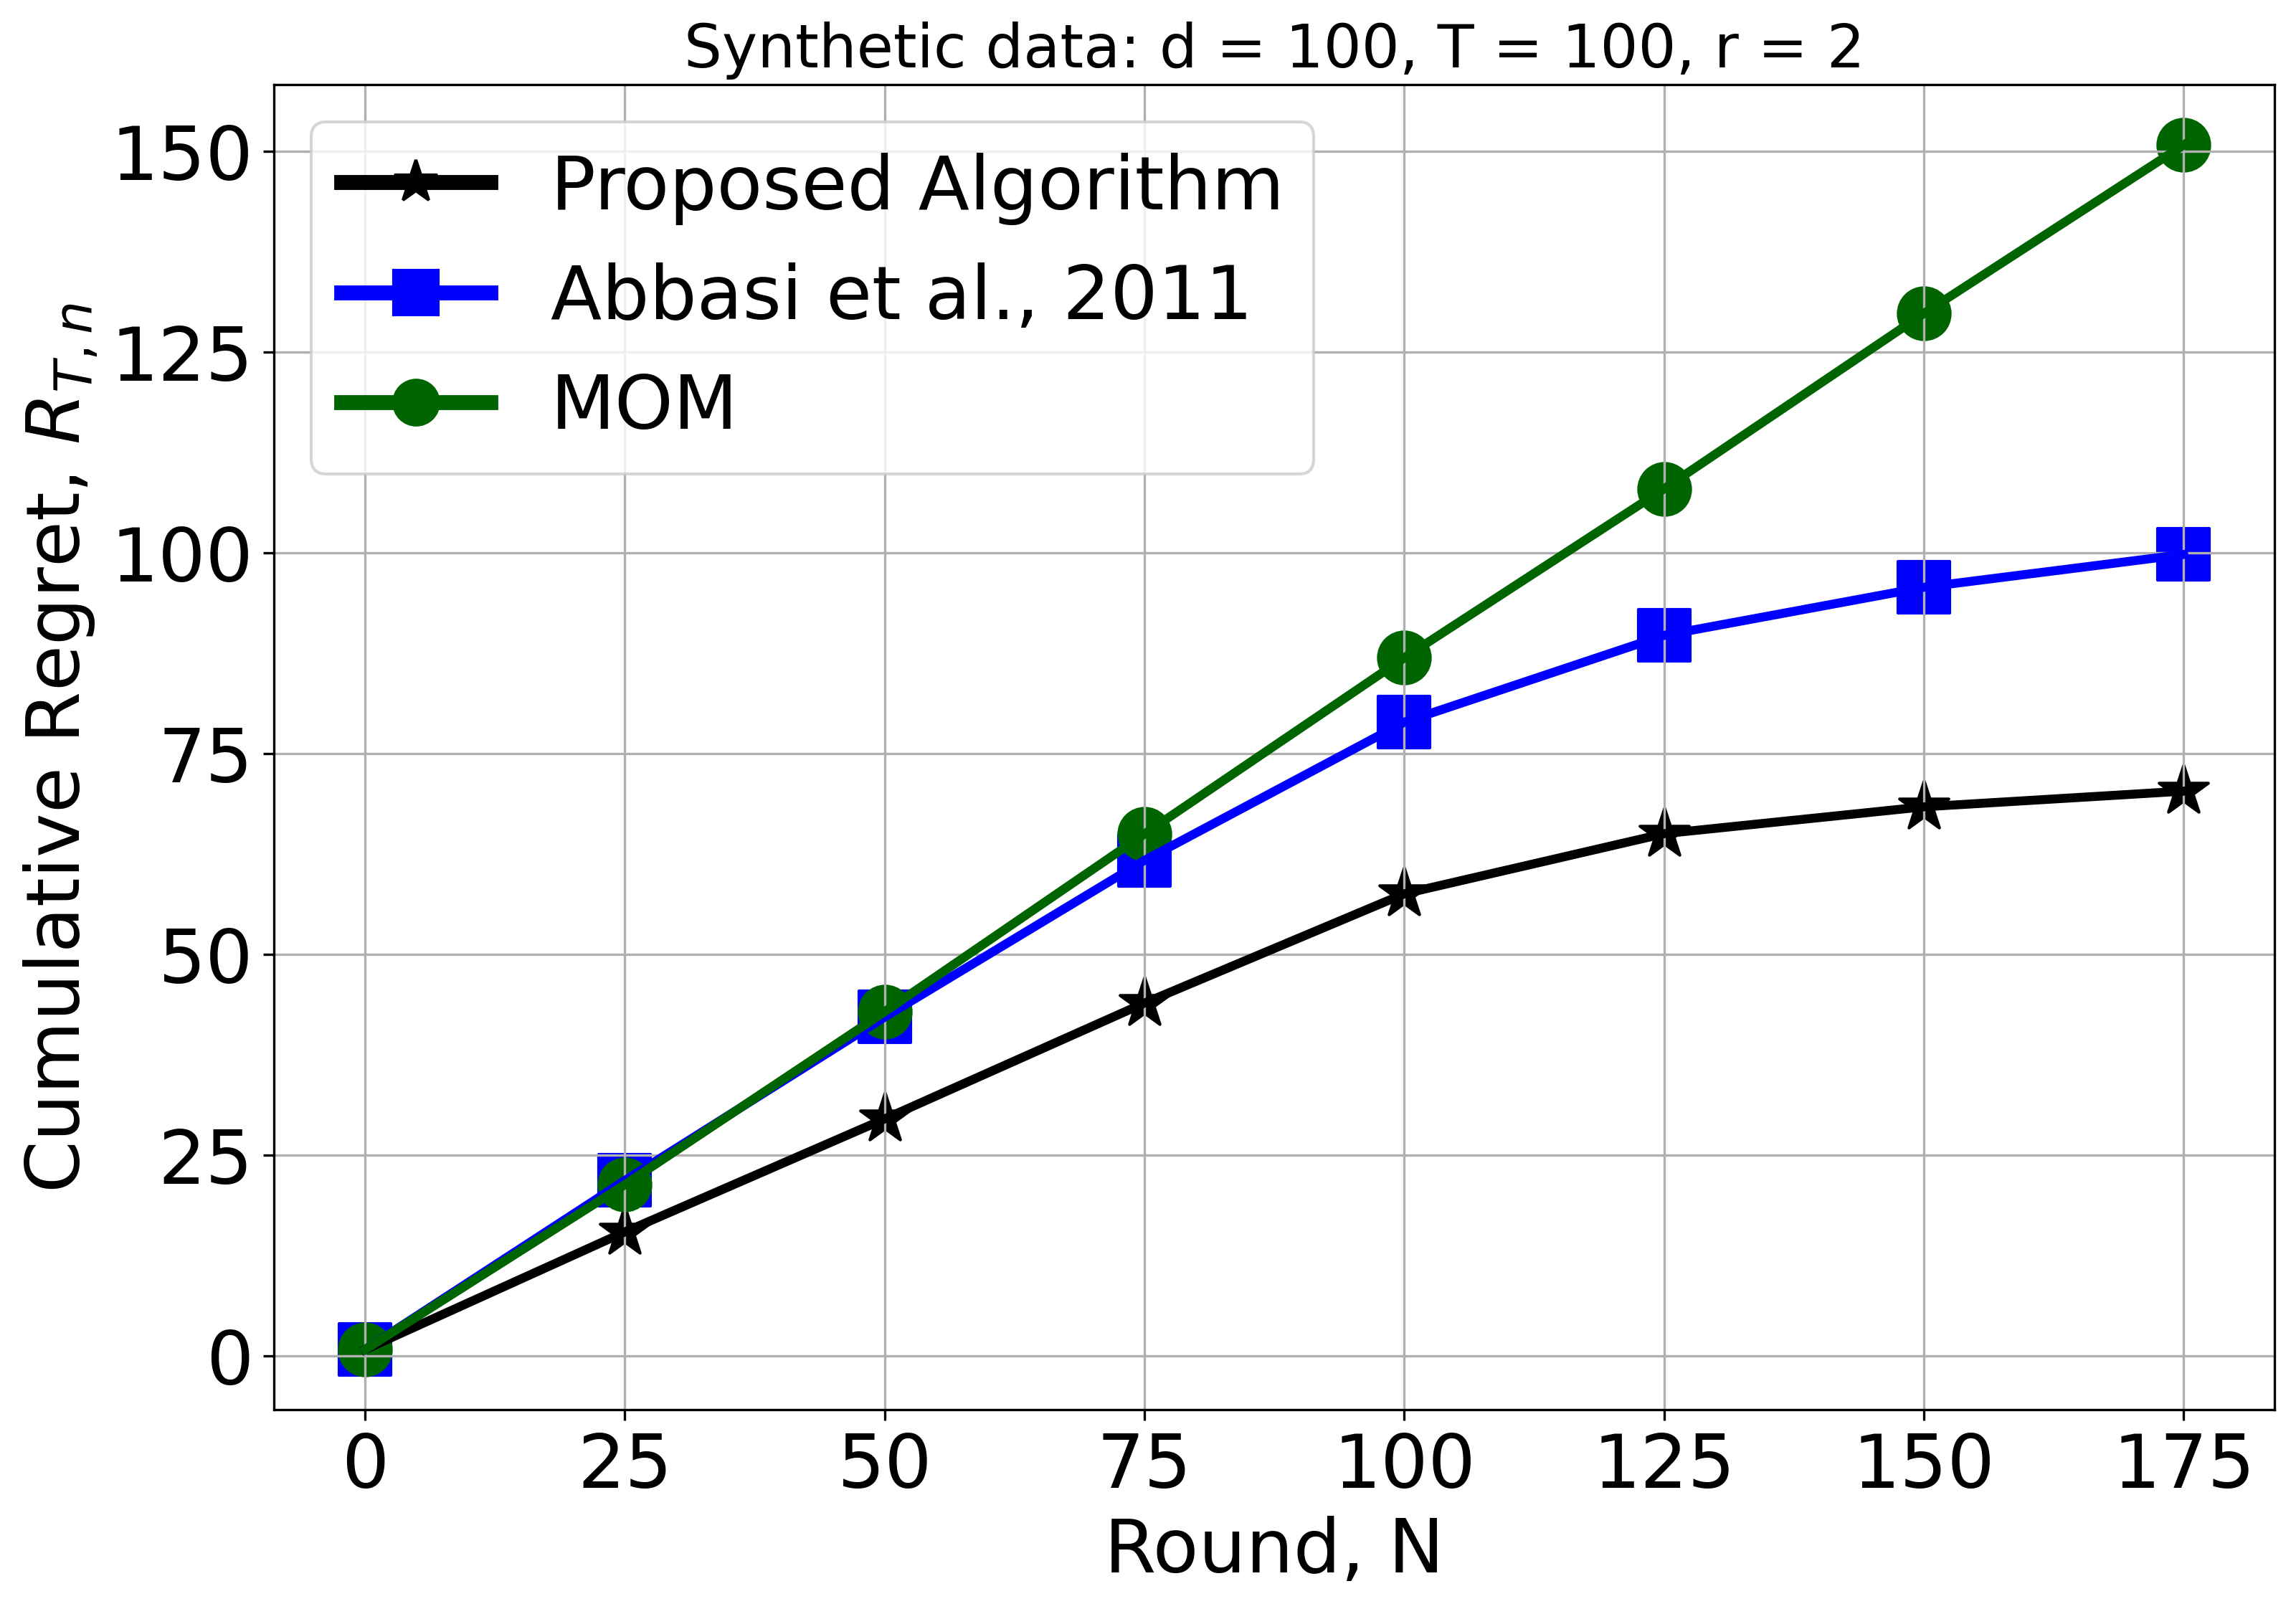

In [15]:
import matplotlib.lines as mlines

plt.figure(figsize=(12, 8), dpi = 300)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

colors = (['black', 'blue', 'darkgreen', 'purple', 'darkred', 'grey'])
markers = ['*', 's', 'o', 'X', '^', 'P']

plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rc('legend', fontsize = 25)

plt.plot(x_proposed[::every_point], y_proposed[::every_point], color = colors[0], linewidth = 3, label = 'Proposed Algorithm')
plt.scatter(x_proposed[::every_point], y_proposed[::every_point], marker = markers[0], color = colors[0], s = 300, label = 'Proposed Algorithm')
plt.plot(x_Abbasi[::every_point], y_Abbasi[::every_point], color = colors[1], linewidth = 3, label = 'Abbasi et al., 2011')
plt.scatter(x_Abbasi[::every_point], y_Abbasi[::every_point], marker = markers[1], color = colors[1], s = 300, label = 'Abbasi et al., 2011')
plt.plot(x_MOM[::every_point], y_MOM[::every_point], color = colors[2], linewidth = 3, label = 'MOM')
plt.scatter(x_MOM[::every_point], y_MOM[::every_point], marker = markers[2], color = colors[2], s = 300, label = 'MOM')

legend_elements = [mlines.Line2D([0], [0], color = colors[0], lw = 5, label = 'Proposed Algorithm', marker = markers[0], markersize = 15),
                   mlines.Line2D([0], [0], color = colors[1], lw = 5, label = 'Abbasi et al., 2011', marker = markers[1], markersize = 15),
                   mlines.Line2D([0], [0], color = colors[2], lw = 5, label = 'MOM', marker = markers[2], markersize = 15)]

plt.grid(True)
plt.xlabel('Round, N', fontsize = 25)
plt.ylabel(r'Cumulative Regret, $R_{T+1,n}$', fontsize = 25)
plt.legend(handles=legend_elements)
plt.title('Synthetic data: d=100, T=200, r=2', fontsize = 20)
plt.savefig('meta_paper.pdf', dpi = 600, bbox_inches = 'tight')
plt.show()
plt.close()

In [16]:
np.save('CR_Trials_Proposed.npy', np.array(CR_Trials, dtype=object))
np.save('CR_Trials_Abbasi.npy', np.array(CR_Trials_Abbasi, dtype=object))
np.save('CR_Trials_MOM.npy', np.array(CR_Trials_MOM, dtype=object))